# Folgendes Skript zeigt die Laufzeitunterschiede zwischen DTs und SVMs

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import svm
from sklearn import tree

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from sklearn.metrics import precision_recall_curve

matrix_helper = MatrixHelper()

def predict(training_data, training_target, test_data, prediction_type):

    start = time.time()

    # Create the SVM or DT
    if (prediction_type == 'svm'):
        m = svm.SVC(kernel='linear', C=0.2)
    elif (prediction_type == 'dt'):
        m = tree.DecisionTreeClassifier()
    else:
        m = svm.LinearSVC(C=pen)

    # Fit prediction_type to the model
    m.fit(training_data, training_target)

    # Predict remaining data
    target_prediction = m.predict(test_data) 

    end = time.time()
    elapsed = (end - start) / 60
    
    return target_prediction, elapsed, target_score
    
# Read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_cla_incl_history.pickle')

feature_matrix = matrices[0]
# feature_matrix = feature_matrix[:1000, :]

rows = matrices[1]
columns = matrices[2]
features_count = feature_matrix.shape[1] - 1

# Create own matrices for vulenrable and not vulnerable entries
vulnerable_matrix, vulnerable_rows = matrix_helper.get_vulnerable_components(feature_matrix, rows)
not_vulnerable_matrix, not_vulnerable_rows = matrix_helper.get_not_vulnerable_components(feature_matrix, rows)


# Split into training sets (2/3) and test sets (1/3)
vulnerable_training, vulnerable_test = matrix_helper.split_training_test(vulnerable_matrix, (2.0/3), vulnerable_rows)
not_vulnerable_training, not_vulnerable_test = matrix_helper.split_training_test(not_vulnerable_matrix, (2.0/3), not_vulnerable_rows)


# Concatenate vulnerable/not-vulnerable
training_matrix = np.concatenate((not_vulnerable_training[0], vulnerable_training[0]), axis=0)
test_matrix = np.concatenate((not_vulnerable_test[0], vulnerable_test[0]), axis=0)
test_rows = not_vulnerable_test[1] + vulnerable_test[1]


# Split into training and target matrices
training_data, training_target = matrix_helper.create_data_target(training_matrix)
test_data, test_target = matrix_helper.create_data_target(test_matrix)


# Train the classification model and predict vulnerrabilities for test data
for clf in ['dt', 'SVLinear']:
    target_prediction, elapsed_time = predict(training_data, training_target, test_data, clf)
    
    precision, recall, thresholds = precision_recall_curve(test_target, target_prediction)

    print('|{}|{:^11.3f}|{:^8.3f}| {} |'.format(clf, precision[1], recall[1], elapsed_time))

    

| Type            | Precision | Recall | Time |
|-------------------------------------|-----------|--------|-----------------|
|dt|   0.593   | 0.617  | 1.15047711531 |
|svm|   0.775   | 0.602  | 9.84284751415 |
|linsvm|   0.736   | 0.631  | 0.0606333851814 |

# Folgendes Skript evaluiert den optimalen penalty parameter durch cross validation

|0.1|   0.766   | 0.589  | 0.274146966139 | 0.943345036706 *| 0.936482903551 |
|0.2|   0.742   | 0.607  | 0.273292501767 | 0.942068305139 | 0.936961372451 *|
|0.3|   0.736   | 0.617  | 0.275732080142 | 0.942068305139 | 0.935844054015 |
|0.4|   0.731   | 0.621  | 0.27314825058 | 0.941749122247 | 0.93520584091 |
|0.5|   0.722   | 0.627  | 0.276482550303 | 0.941110756463 | 0.933929541986 |
|0.6|   0.716   | 0.634  | 0.274782900016 | 0.940791573572 | 0.932812350836 |
|0.7|   0.713   | 0.637  | 0.276337250074 | 0.940631982126 | 0.931057455727 |
|0.8|   0.711   | 0.639  | 0.279982133706 | 0.94047239068 | 0.931217199932 |
|0.9|   0.708   | 0.639  | 0.280481302738 | 0.940153207788 | 0.931536433771 |
|1.0|   0.705   | 0.639  | 0.27504661878 | 0.93967443345 | 0.931855540324 |
|1.1|   0.701   | 0.644  | 0.276677866777 | 0.939514842004 | 0.931536433771 |
|1.2|   0.694   | 0.644  | 0.278191216787 | 0.938557293329 | 0.931536433771 |
|1.3|   0.691   | 0.642  | 0.278110484282 | 0.938078518991 | 0.9305

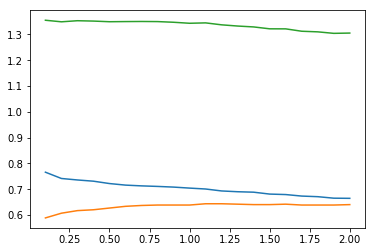

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn import svm
from sklearn import tree

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score

matrix_helper = MatrixHelper()

def predict(training_data, training_target, test_data, test_target, pen):
    prediction_type = 'SVLinear'
    start = time.time()

    # Create the SVM or DT
    if (prediction_type == 'svm'):
        m = svm.SVC(kernel='linear', C=0.2)
    elif (prediction_type == 'dt'):
        m = tree.DecisionTreeClassifier()
    else:
        m = svm.LinearSVC(C=pen)

    # Fit prediction_type to the model
    m.fit(training_data, training_target)

    # Predict remaining data
    target_prediction = m.predict(test_data)
    target_score = m.score(test_data, test_target)
    scores = cross_val_score(m, test_data, test_target, cv=5)
    cross_score = scores.mean()

    end = time.time()
    elapsed = (end - start) / 60
    
    return target_prediction, elapsed, target_score, cross_score
    
# Read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_cla_incl_history.pickle')

feature_matrix = matrices[0]
# feature_matrix = feature_matrix[:1000, :]

rows = matrices[1]
columns = matrices[2]
features_count = feature_matrix.shape[1] - 1

# Create own matrices for vulenrable and not vulnerable entries
vulnerable_matrix, vulnerable_rows = matrix_helper.get_vulnerable_components(feature_matrix, rows)
not_vulnerable_matrix, not_vulnerable_rows = matrix_helper.get_not_vulnerable_components(feature_matrix, rows)


# Split into training sets (2/3) and test sets (1/3)
vulnerable_training, vulnerable_test = matrix_helper.split_training_test(vulnerable_matrix, (2.0/3), vulnerable_rows)
not_vulnerable_training, not_vulnerable_test = matrix_helper.split_training_test(not_vulnerable_matrix, (2.0/3), not_vulnerable_rows)


# Concatenate vulnerable/not-vulnerable
training_matrix = np.concatenate((not_vulnerable_training[0], vulnerable_training[0]), axis=0)
test_matrix = np.concatenate((not_vulnerable_test[0], vulnerable_test[0]), axis=0)
test_rows = not_vulnerable_test[1] + vulnerable_test[1]


# Split into training and target matrices
training_data, training_target = matrix_helper.create_data_target(training_matrix)
test_data, test_target = matrix_helper.create_data_target(test_matrix)

precision_list = []
recall_list = []
time_list = []
score_list = []
cross_score_list = []
c_range = [(i+1)/10.0 for i in range(20)]
# Train the classification model and predict vulnerrabilities for test data
for pen in c_range:
    target_prediction, elapsed_time, target_score, cross_score = predict(training_data, training_target, test_data, test_target, pen)
    
    precision, recall, thresholds = precision_recall_curve(test_target, target_prediction)
    precision_list.append(precision[1])
    recall_list.append(recall[1])
    time_list.append(elapsed_time)
    score_list.append(target_score)
    cross_score_list.append(cross_score)

index_highest_cross_score = cross_score_list.index(max(cross_score_list))
index_highest_score = score_list.index(max(score_list))
for i in range(len(c_range)):
    if (i == index_highest_score):
        print('|{}|{:^11.3f}|{:^8.3f}| {} | {} *| {} |'.format(
            c_range[i], precision_list[i], recall_list[i], time_list[i], score_list[i], cross_score_list[i]))
    elif (i == index_highest_cross_score):
        print('|{}|{:^11.3f}|{:^8.3f}| {} | {} | {} *|'.format(
            c_range[i], precision_list[i], recall_list[i], time_list[i], score_list[i], cross_score_list[i]))
    else:
        print('|{}|{:^11.3f}|{:^8.3f}| {} | {} | {} |'.format(
            c_range[i], precision_list[i], recall_list[i], time_list[i], score_list[i], cross_score_list[i]))

    
plt.plot(c_range, precision_list)
plt.plot(c_range, recall_list)